In [64]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import random

In [65]:
    def read_data( hf, target_device, house_list):
        """Load data of houses
        """

        if len(house_list) == 0:
            return [], []

        else:
            aggregates = []
            targets = []
            timestamps=[]
        
            for house in house_list:

                aggregate = hf[house]['aggregate'][:]
                target = hf[house][target_device][:]
                timestamp=hf[house]['unix'][:]
                
                aggregates.append(aggregate)
                targets.append(target)
                timestamps.append(timestamp)
            aggregates = np.concatenate(aggregates, axis=0)
            targets = np.concatenate(targets, axis=0)
            times=np.concatenate(timestamps,axis=0)
            
            return aggregates, targets,timestamps

In [66]:
def produce_data(train_x,train_y,timestamps,m_off,m_on,threshold):
    data = train_y
    index = timestamps
    chunk = pd.Series(data, index=index)
    min_off_duration=m_off
    min_on_duration=m_on
    border=1
    on_power_threshold=threshold
    when_on = chunk >= on_power_threshold
    

    state_changes = when_on.astype(np.int8).diff()
    del when_on
    switch_on_events = np.where(state_changes == 1)[0]
    switch_off_events = np.where(state_changes == -1)[0]

    del state_changes

    

  
    if switch_off_events[0] < switch_on_events[0]:
        switch_off_events = switch_off_events[1:]
        
           
    if switch_on_events[-1] > switch_off_events[-1]:
        switch_on_events = switch_on_events[:-1]
        
    assert len(switch_on_events) == len(switch_off_events)
    a=chunk.index[switch_on_events[1:]]
    b=chunk.index[switch_off_events[:-1]]
    c=[]
    d=[]
    for i in range(0,len(a)):
        c.append(a[i])
    off_durations=[]

    for j in range(0,len(b)):
        d.append(b[j])

    if min_off_duration > 0:
        off_durations = np.array(c) - np.array(d)
        above_threshold_off_durations = np.where(
            off_durations >= min_off_duration)[0]
        switch_off_events = switch_off_events[
                np.concatenate([above_threshold_off_durations,
                                [len(switch_off_events)-1]])]
        switch_on_events = switch_on_events[
                np.concatenate([[0], above_threshold_off_durations+1])]
        assert len(switch_on_events) == len(switch_off_events)
    activations = []
    for on, off in zip(switch_on_events, switch_off_events):
        duration = (chunk.index[ off] - chunk.index[on])
        if duration < min_on_duration:
            continue
        on -= 1 + border
        if on < 0:
            on = 0
        off += border
        activation = chunk.iloc[on:off]
        if not activation.isnull().values.any() and len(activation)<300:
            activations.append(activation)
          
    

    chunk_aggregation=pd.Series(train_x, timestamps)
    state_agg=[]
    state_app=[]
    for i in range (1,len(activations)):
        index_start=chunk.index.get_loc(activations[i-1].index[-1]+60)
        index_end=chunk.index.get_loc(activations[i].index[0] )
        state_temporary_agg=np.array(chunk_aggregation.iloc[index_start:index_end].tolist())    
        state_temporary_app=np.array(chunk.iloc[index_start:index_end].tolist())
        ind=np.where(state_temporary_app<=threshold)
        state_tem_agg=state_temporary_agg[ind]
        state_tem_app=state_temporary_app[ind]
        state_agg.append(state_tem_agg.tolist())    
        state_app.append(state_tem_app.tolist())    
    aggregation=[]
    sub=[]
    for i in range(0,len(activations)-1):
    
        rm=random.randint(0,len(state_app)-1)
        rm_act=random.randint(0,len(activations)-1)
 
        while not len(activations[rm_act])<=len(state_app[rm]) :
            rm=random.randint(0,len(state_app)-1)
       
        state_off_app=state_app[rm].copy()
        state_off_agg=state_agg[rm].copy()
    
        for j in range(0,len(activations[rm_act])):
            state_off_app[j]=state_off_app[j]+activations[rm_act].tolist()[j]
            state_off_agg[j]=state_off_agg[j]+activations[rm_act].tolist()[j]
    
        del activations[rm_act]
        rm1=random.randint(0,len(state_agg)-1)
       
        state_off_agg.extend(state_agg[rm1])
        state_off_app.extend(state_app[rm1])
    
  
        temporary_agg=state_off_agg
        temporary_app=state_off_app
        aggregation.extend(temporary_agg)
        sub.extend(temporary_app)
    
    df=pd.DataFrame({target_device:sub,'Aggregate':aggregation}) 
    path="data/house1.csv"
    df.to_csv(path, index=False, header=True)
     
    






In [67]:
# for i in ["house1","house2","house3","house5","house6","house7","house9"]:
#     produce_data('dishwasher',i,1800,1800,10,10)

In [68]:
def data_resample(da):
    random_sample = pd.DataFrame(train_x, columns=['random_sample'])
    random_sample['time'] = pd.date_range(start='1/1/2018', periods=len(random_sample), freq=pd.Timedelta(10, "s"))
    random_sample.set_index('time', inplace=True)
    random_sample = random_sample.resample('1min').mean()
    random_sample = np.array(random_sample.values).reshape(-1) 
    val=random_sample
    return val

In [69]:
x=[]

for i in ["house5","house7","house10","house18"]:
    train_house_list=[i]
    target_device='washingmachine'
    hf = h5py.File('data.h5', 'r')
    (train_x, train_y,timestamps) = read_data(hf, target_device, train_house_list)
    random_sample = pd.DataFrame(train_x, columns=['random_sample'])
    random_sample['time'] = pd.date_range(start='1/1/2018', periods=len(random_sample), freq=pd.Timedelta(10, "s"))
    random_sample.set_index('time', inplace=True)
    random_sample = random_sample.resample('1min').mean()
    random_sample = np.array(random_sample.values).reshape(-1) 
    x.extend(random_sample )
    del random_sample


In [70]:
y=[]
for i in ["house5","house7","house10","house18"]:
    train_house_list=[i]
    target_device='washingmachine'
    hf = h5py.File('data.h5', 'r')
    (train_x, train_y,timestamps) = read_data(hf, target_device, train_house_list)
    random_sample = pd.DataFrame(train_y, columns=['random_sample'])
    random_sample['time'] = pd.date_range(start='1/1/2018', periods=len(random_sample), freq=pd.Timedelta(10, "s"))
    random_sample.set_index('time', inplace=True)
    random_sample = random_sample.resample('1min').mean()
    random_sample = np.array(random_sample.values).reshape(-1) 
    y.extend(random_sample)
    del random_sample


In [71]:
print(x[50:80])
print(y[50:80])

[276.33334, 279.33334, 275.41666, 278.16666, 278.0, 273.58334, 274.75, 281.91666, 274.75, 270.66666, 276.5, 281.72223, 287.33334, 365.33334, 350.5, 354.41666, 350.58334, 345.5, 344.0, 341.5, 336.83334, 339.66666, 340.33334, 347.5, 357.91666, 371.1389, 369.58334, 343.25, 289.41666, 290.16666]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


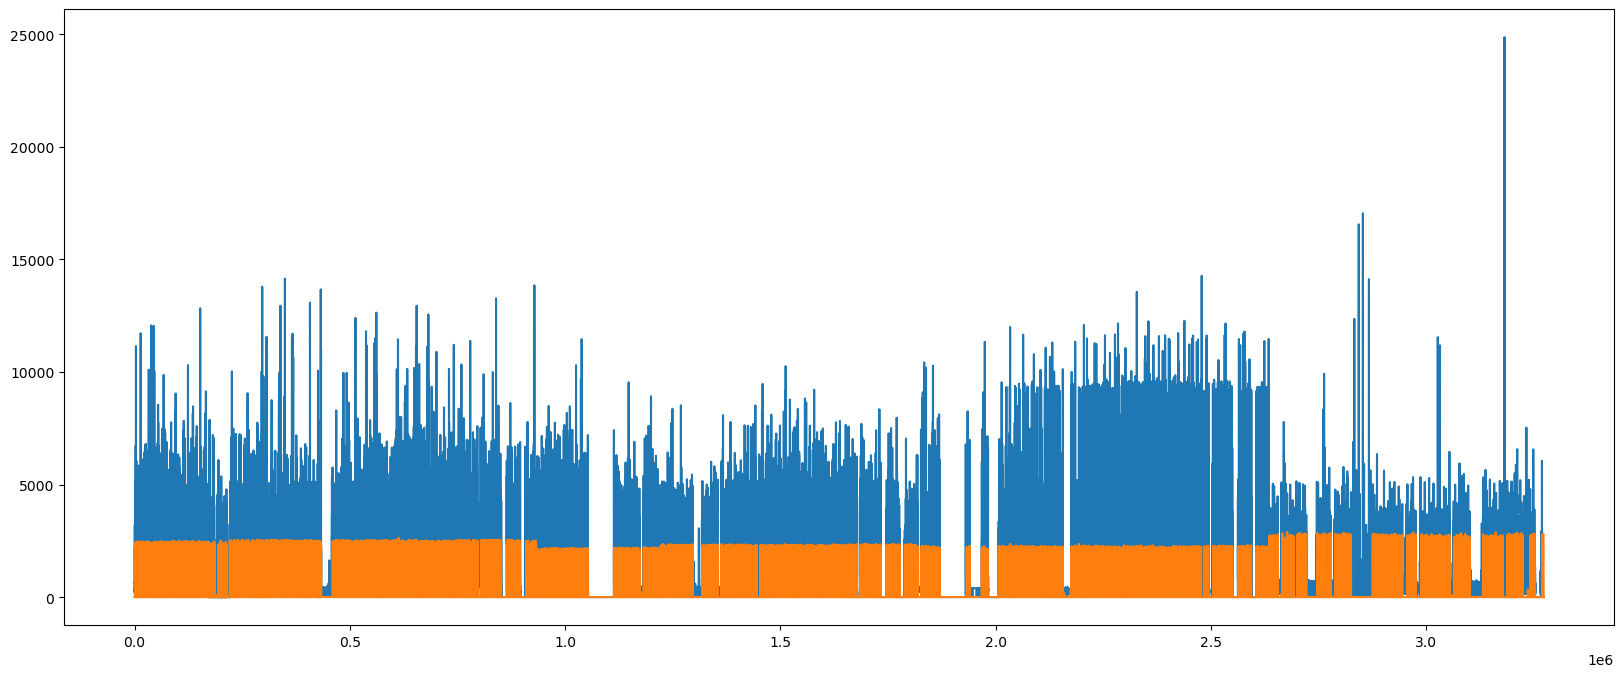

In [72]:
plt.figure(figsize=(20,8))
plt.plot(x[1:-1])
plt.plot(y[1:-1])

In [73]:
train_house_list=["house26"]
target_device='washingmachine'
hf = h5py.File('experiment_data/uk-washingmachine.h5', 'r')
(uktrain_x, uktrain_y,timestamps) = read_data(hf, target_device, train_house_list)
print(uktrain_x[1:20])
print(uktrain_y[1:20])

[ 774.5  772.5  778.   760.   760.  2312.5 2270.  2277.  2280.5 2255.5
 2245.5 2245.5  769.   758.   758.   758.   758.   758.   758.5]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [74]:
x.extend(uktrain_x)
y.extend(uktrain_y)
timestamps= [i * 60 for i in range(len(y))]
produce_data(x,y,timestamps,160,1800,20)


In [75]:
application='washingmachine'
target_device=application
train_house_list=['house27']
hf = h5py.File('experiment_data/uk-washingmachine.h5', 'r')
(train_x, train_y,timestamps) = read_data(hf, target_device, train_house_list)
df=pd.DataFrame({application:train_y,'Aggregate':train_x})
path="data/house2.csv"
df.to_csv(path, index=False, header=True)
    

In [76]:
# def produce_data_vt(application,house):
   
    
#     target_device=application
#     train_house_list=[house]
#     hf = h5py.File('data.h5', 'r')
#     (train_x, train_y,timestamps) = read_data(hf, target_device, train_house_list)
#     df=pd.DataFrame({application:train_y,'Aggregate':train_x})
#     path="data/"+house+".csv"
#     df.to_csv(path, index=False, header=True)
    

In [77]:
# for i in ["house10","house11","house13","house15","house16","house18","house20","house21"]:
#     produce_data_vt('dishwasher',i)